## Практическое задание

1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете. 
2. Опишите  результата. Что помогло повысить точность?

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
import tensorflow as tf


# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [7]:
import cv2

Лекция 01:26

Загружаем картинки для сегментации (имена почти одинаковые: изображение.png - это сам кадр и изображение (1).png - это разметка)

Вот так загружаем с локального диска

In [8]:
# from google.colab import files
# uploaded = files.upload()

In [9]:
!pip install rarfile

In [10]:
import rarfile

rf = rarfile.RarFile("small_segment.rar")
for f in rf.infolist():
    print(f.filename, f.file_size)
    if f.filename == "README":
        print(rf.read(f))
rf.extractall()

labels/00_000200.png 19401
labels/00_000400.png 14502
labels/00_000600.png 19818
labels/00_000800.png 13554
labels/00_001000.png 14496
labels/00_001200.png 17371
labels/00_001400.png 12431
labels/00_001600.png 16390
labels/00_001800.png 16646
labels/00_002000.png 14844
labels/00_002200.png 14011
labels/00_002400.png 16921
labels/00_002600.png 15822
labels/00_002800.png 13681
labels/00_003000.png 13980
labels/00_003200.png 15122
labels/00_003400.png 13978
images/00_000200.png 791603
images/00_000400.png 816531
images/00_000600.png 862976
images/00_000800.png 836923
images/00_001000.png 829576
images/00_001200.png 822001
images/00_001400.png 858981
images/00_001600.png 797385
images/00_001800.png 850589
images/00_002000.png 818966
images/00_002200.png 641760
images/00_002400.png 714888
images/00_002600.png 774166
images/00_002800.png 890605
images/00_003000.png 837876
images/00_003200.png 755342
images/00_003400.png 695524
labels/ 0
images/ 0


In [11]:
!ls

images	labels	sample_data  small_segment.rar


#Загружаем и уменьшаем картинки

можно обойтись исходным рахзмером или взять другой

ВАЖНО - размер по обеим сторонам должен делиться на 2 несколько раз (сколько будет сжатий кадра)

In [12]:
PAHT_label = 'labels/'
PAHT_image = 'images/'

In [13]:
import os, fnmatch
imag = os.listdir(PAHT_label)
imag_label = os.listdir(PAHT_image)

In [14]:
images = []
segments = []
image_size = (200,600)
for i_name in imag:
  images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))
  segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))

Посмотрели на входные кадры

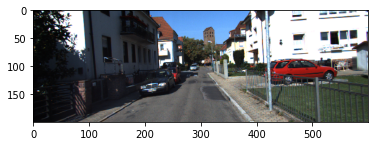

In [15]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

Посмотрим на цели

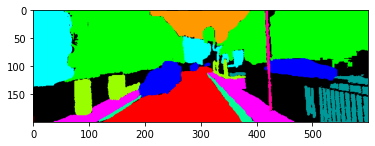

In [16]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

#Создаём обучающую выборку

Собираем входные примеры:

In [17]:
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

In [18]:
print(xTrain_Test.shape)

(17, 200, 600, 3)


Порстроим цвета , воспринимаемого диапазона для сегментированной картинки - это результат разметки, которую принесет разметчик

Color Coding:

Name	(r,g,b)	    7-Class mapping

Car	  ( 0, 0,255)	Object

Road	(255, 0, 0)	Road

Mark	(255,255, 0)	Road

Building	( 0,255, 0)	Building

Sidewalk	(255, 0,255)	Road

Tree/Bush	( 0,255,255)	Tree/Bush

Pole	(255, 0,153)	Sign/Pole

Sign	(153, 0,255)	Sign/Pole

Person	( 0,153,255)	Object

Wall	(153,255, 0)	Building

Sky	(255,153, 0)	Sky

Curb	( 0,255,153)	Road

Grass/Dirt	( 0,153,153)	Grass/Dirt

Void	( 0, 0, 0)	Void



Делаем конвертер в one-hot_encoding для выходных примеров

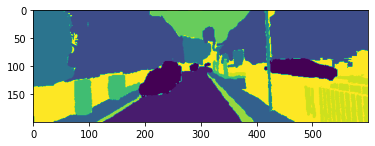

In [19]:
def Color2index(y):
  arr_col=[[0,0,255],[255,0,0],[255,255,0],[0,255,0],[255,0,255],[0,255,255],[255,0,153],[153,0,255],[0,153,255],[153,255,0],[255,153,0],[0,255,153],[0,153,153],[0,0,0]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  

In [20]:
np.sum(cat_yi[100:,:100,1] )

21.0

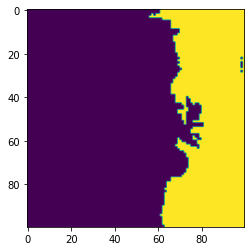

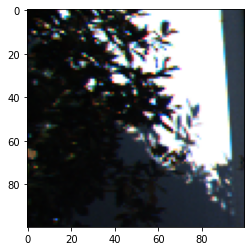

In [21]:
plt.imshow(cat_yi[:100, :100, 3])
plt.show()
plt.imshow(xTrain_Test[0, :100, :100, :]/255)
plt.show()

In [22]:
cat_yi.shape

(200, 600, 14)

Сегментированную картинку в  One hot encoding (разметка на 14 классов)**

In [23]:
yTrain_Test = []

for seg in segments:
  y_cat, _, _ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [24]:
print(yTrain_Test.shape)

(17, 200, 600, 14)


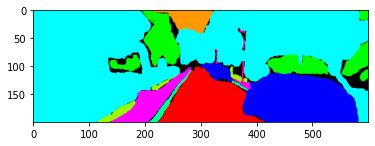

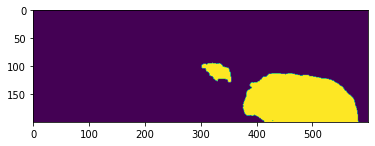

In [25]:
n = 10
plt.imshow(segments[n].convert('RGBA'))
plt.show()
img = yTrain_Test[n][:, :, 0]
plt.imshow(img.astype(float))
plt.show()

Делим на тест и трейн по числу N

In [26]:
N = 15
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [27]:
yTest.shape

(2, 200, 600, 14)

In [28]:
print(xTrain.shape)
print(yTrain.shape)

(15, 200, 600, 3)
(15, 200, 600, 14)


#Создаём и обучаем U-net

In [29]:
from tensorflow.keras.utils import plot_model

In [30]:
def Unet(num_classes = 14, input_shape= (200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 600, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 600, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 200, 600, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

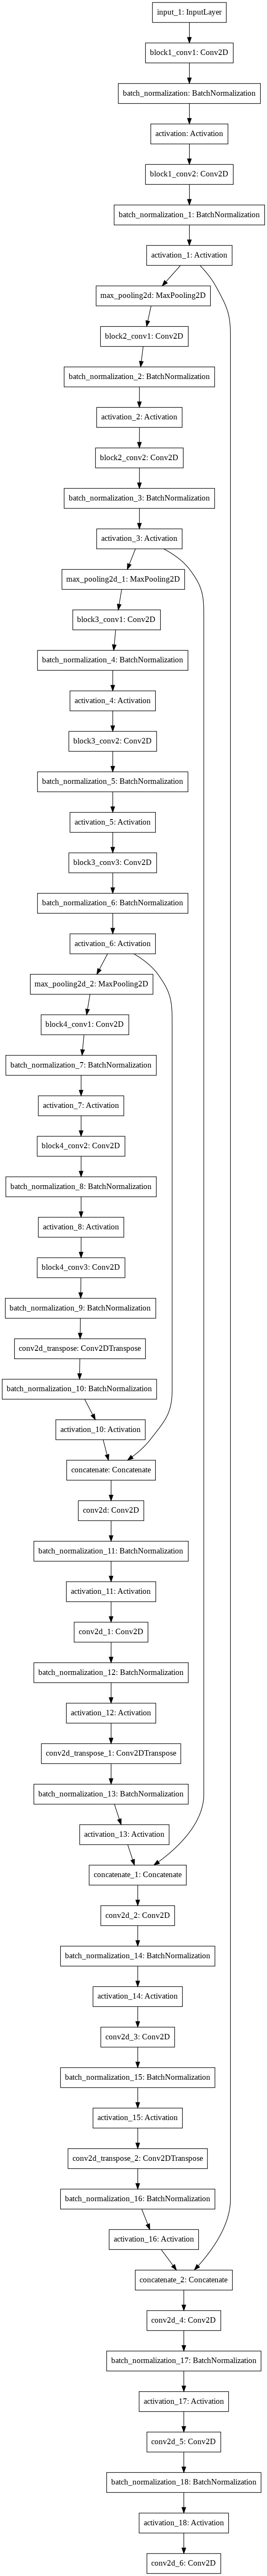

In [31]:
modelC = Unet(14, (200, 600, 3))
plot_model(modelC, to_file='modelC.png')

Лекция 01:43

In [32]:
history = modelC.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/10
15/15 [==============================] - 42s 564ms/step - loss: 1.9869 - dice_coef: 0.2319 - val_loss: 209.0362 - val_dice_coef: 0.2868
Epoch 2/10
15/15 [==============================] - 8s 558ms/step - loss: 1.5513 - dice_coef: 0.3498 - val_loss: 79.4325 - val_dice_coef: 0.2648
Epoch 3/10
15/15 [==============================] - 8s 558ms/step - loss: 1.4077 - dice_coef: 0.3542 - val_loss: 312.8746 - val_dice_coef: 0.2754
Epoch 4/10
15/15 [==============================] - 8s 565ms/step - loss: 1.3435 - dice_coef: 0.3853 - val_loss: 51.3840 - val_dice_coef: 0.2780
Epoch 5/10
15/15 [==============================] - 8s 561ms/step - loss: 1.2923 - dice_coef: 0.4112 - val_loss: 26.8808 - val_dice_coef: 0.2913
Epoch 6/10
15/15 [==============================] - 8s 560ms/step - loss: 1.2692 - dice_coef: 0.4217 - val_loss: 8.9471 - val_dice_coef: 0.3304
Epoch 7/10
15/15 [==============================] - 8s 526ms/step - loss: 1.2571 - dice_coef: 0.4364 - val_loss: 46.7662 - val_d

In [ ]:
# сохранить веса модели.
# modelC.save_weights('modelC_1.h5')

In [33]:
# загрузить веса модели:
# modelC.load_weights('modelC_1.h5')

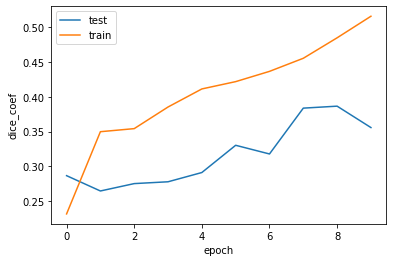

In [33]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [34]:
history = modelC.fit(xTrain, yTrain, epochs=10, batch_size=1, validation_data=(xTrain, yTrain))

Epoch 1/10
15/15 [==============================] - 9s 577ms/step - loss: 1.0594 - dice_coef: 0.5072 - val_loss: 5.0212 - val_dice_coef: 0.4212
Epoch 2/10
15/15 [==============================] - 8s 557ms/step - loss: 1.0594 - dice_coef: 0.5234 - val_loss: 9.0784 - val_dice_coef: 0.3778
Epoch 3/10
15/15 [==============================] - 8s 520ms/step - loss: 1.0498 - dice_coef: 0.5206 - val_loss: 3.4297 - val_dice_coef: 0.3311
Epoch 4/10
15/15 [==============================] - 8s 563ms/step - loss: 0.9481 - dice_coef: 0.5496 - val_loss: 1.8401 - val_dice_coef: 0.4790
Epoch 5/10
15/15 [==============================] - 8s 523ms/step - loss: 0.8978 - dice_coef: 0.5728 - val_loss: 2.3676 - val_dice_coef: 0.3826
Epoch 6/10
15/15 [==============================] - 8s 524ms/step - loss: 0.8530 - dice_coef: 0.5883 - val_loss: 1.2212 - val_dice_coef: 0.6135
Epoch 7/10
15/15 [==============================] - 8s 561ms/step - loss: 0.8090 - dice_coef: 0.6054 - val_loss: 1.2614 - val_dice_coef:

####**Ответ** рез-ты вполне отличный val_dice_coef до 0,6135 

In [35]:
pred = modelC.predict(xTest)
print(pred.shape)

(2, 200, 600, 14)


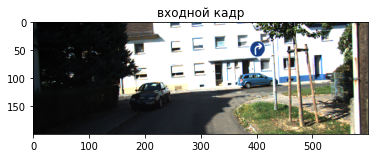

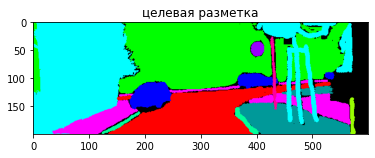

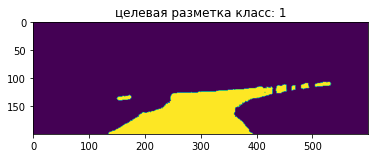

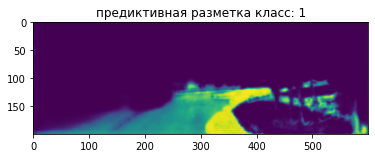

In [46]:
n = 1
class_ =1
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

####**Ответ** дорога вполне отличима

Лекция 01:49 Использование претренированной Unet

In [47]:
 pre_trained_model = VGG16(input_shape=xTest.shape[1:], include_top=False, weights="imagenet")

58900480/58889256 [==============================] - 2s 0us/step


In [48]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 600, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 150, 128)      0     

In [49]:
def bloc_transpose(x,block_out, numb_filter = [256,128]):
  x = concatenate([x, block_out])
  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # UP 
  x = Conv2DTranspose(numb_filter[1], (2, 2), strides=(2, 2), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [50]:
def unet_pre_train(num_classes = 13, input_shape= (200, 600, 3)):    
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:18]:
      # Отключение(заморозка) обучения претренированной сети
      layer.trainable = False

    x = pre_trained_model.layers[13].output # конец сверток
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output # первое уменьшение размера
    img_input = pre_trained_model.inputs
    print(block_4_out)
    print(block_3_out)
    print(block_2_out)
    # UP 1

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x, block_4_out, numb_filter = [256,128])
    

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_3_out, numb_filter = [128,64])
    

    # UP 3
  

    # добавили перенос из понижаюшего плеча VGG16
    x = bloc_transpose(x,block_2_out, numb_filter = [64,32])


    # UP 4
   
    
    #
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

KerasTensor(type_spec=TensorSpec(shape=(None, 25, 75, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 50, 150, 128), dtype=tf.float32, name=None), name='block2_pool/MaxPool:0', description="created by layer 'block2_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100, 300, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 600, 64) 1792        input_3[0][0]         

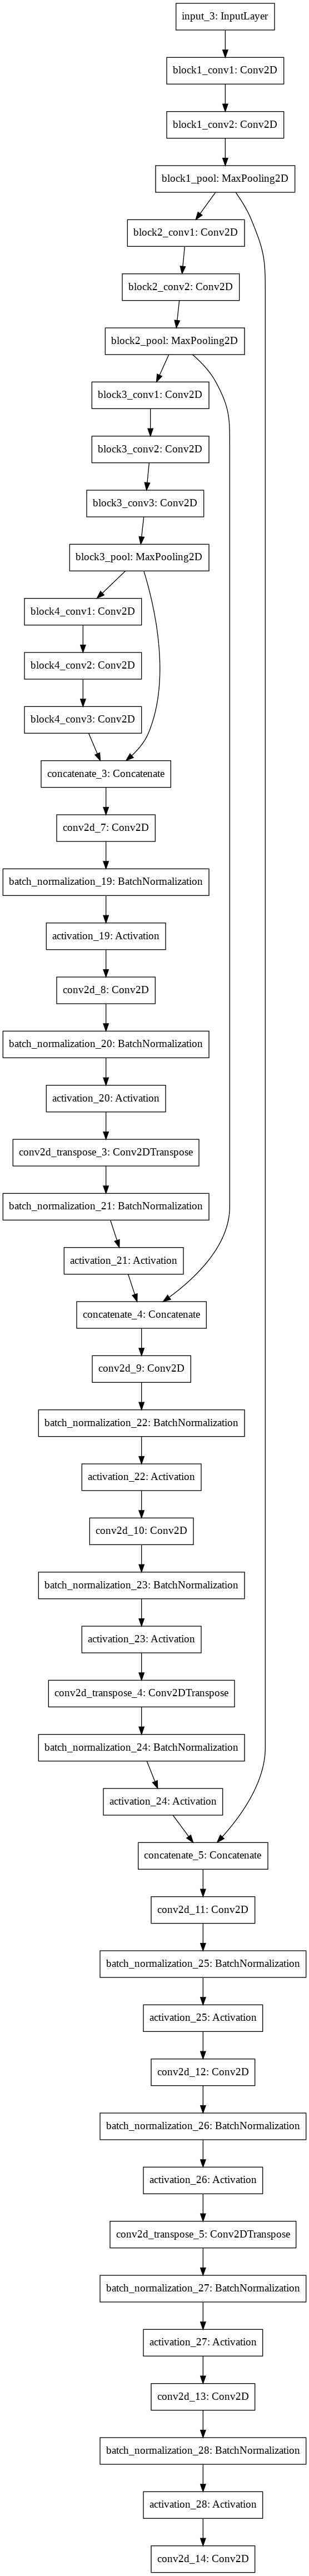

In [51]:
modelU = unet_pre_train(num_classes = 14, input_shape= (200, 600, 3))
plot_model(modelU, to_file='modelU.png')

In [52]:
from IPython.display import clear_output

In [53]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    Ipred = self.model(xTest[:1])

    k = Ipred.shape[3]
    if k>4:
      k = 4
    print('Predict')
    plt.figure(figsize = (5*k,3))
    plt.ylabel('predict')
    for i in range(k):
      plt.subplot(1,k+1,i+1)
      plt.imshow(Ipred[0,:,:,i])
    
    plt.show() 
    print('True') 
    plt.figure(figsize = (5*k,3))
    plt.ylabel('predict')
    for i in range(k):
      plt.subplot(1,k+1,i+1)
      plt.imshow(yTest[0,:,:,i])
    
    plt.show()

    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/40
5/5 [==============================] - 13s 1s/step - loss: 2.3351 - dice_coef: 0.1583 - val_loss: 2.6360 - val_dice_coef: 0.2147
Predict


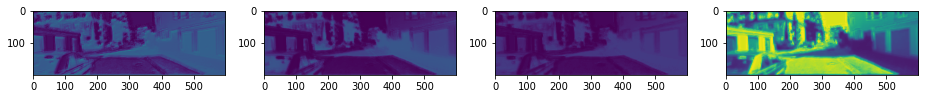

True


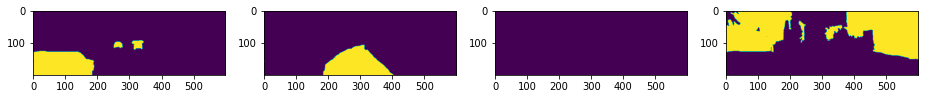


Sample Prediction after epoch 1

Epoch 2/40
5/5 [==============================] - 4s 791ms/step - loss: 1.7246 - dice_coef: 0.3014 - val_loss: 2.4682 - val_dice_coef: 0.2087
Predict


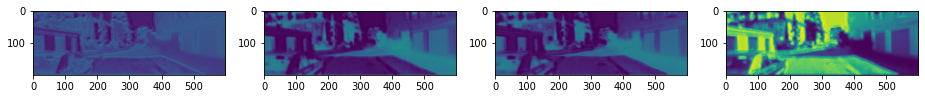

True


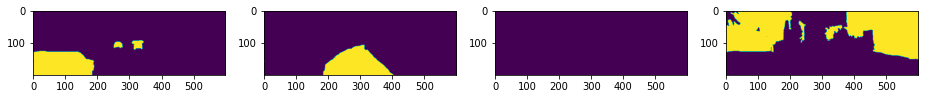


Sample Prediction after epoch 2

Epoch 3/40
5/5 [==============================] - 4s 784ms/step - loss: 1.5751 - dice_coef: 0.3504 - val_loss: 2.2256 - val_dice_coef: 0.1947
Predict


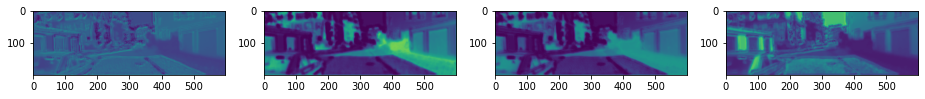

True


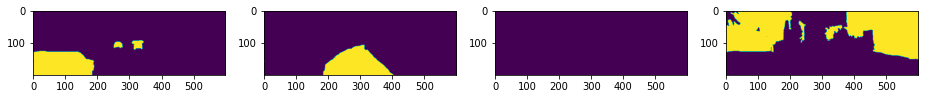


Sample Prediction after epoch 3

Epoch 4/40
5/5 [==============================] - 5s 1s/step - loss: 1.5382 - dice_coef: 0.3285 - val_loss: 2.2017 - val_dice_coef: 0.2177
Predict


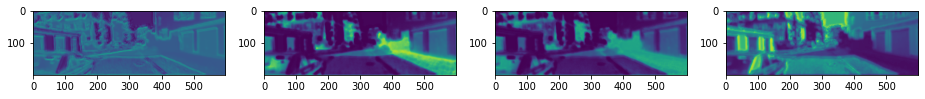

True


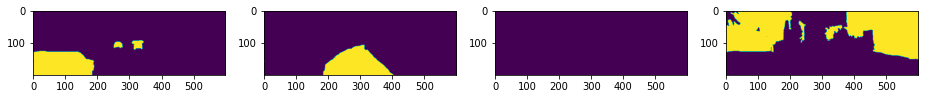


Sample Prediction after epoch 4

Epoch 5/40
5/5 [==============================] - 4s 798ms/step - loss: 1.4207 - dice_coef: 0.3711 - val_loss: 2.2335 - val_dice_coef: 0.2012
Predict


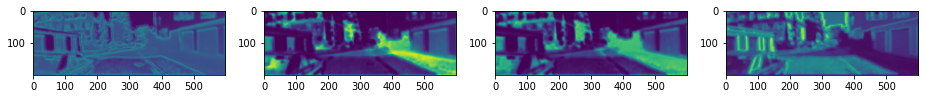

True


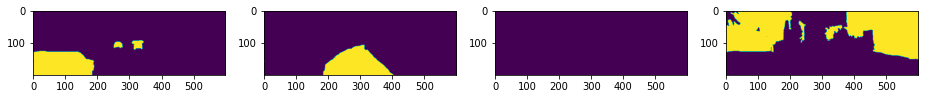


Sample Prediction after epoch 5

Epoch 6/40
5/5 [==============================] - 5s 1s/step - loss: 1.3411 - dice_coef: 0.3961 - val_loss: 2.0947 - val_dice_coef: 0.1926
Predict


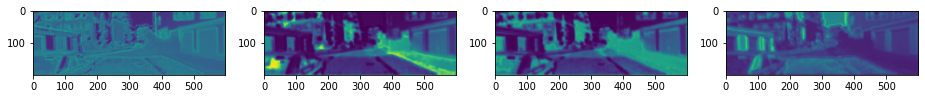

True


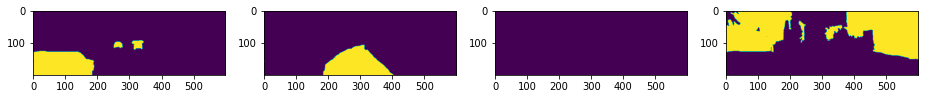


Sample Prediction after epoch 6

Epoch 7/40
5/5 [==============================] - 4s 789ms/step - loss: 1.2825 - dice_coef: 0.4065 - val_loss: 2.0762 - val_dice_coef: 0.1794
Predict


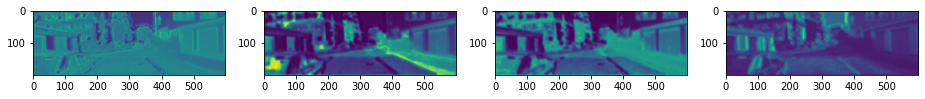

True


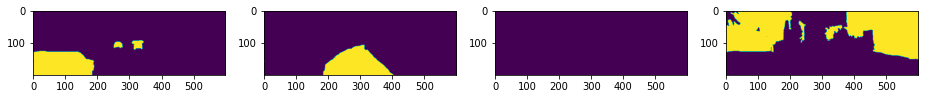


Sample Prediction after epoch 7

Epoch 8/40
5/5 [==============================] - 4s 791ms/step - loss: 1.2324 - dice_coef: 0.4306 - val_loss: 2.0591 - val_dice_coef: 0.1749
Predict


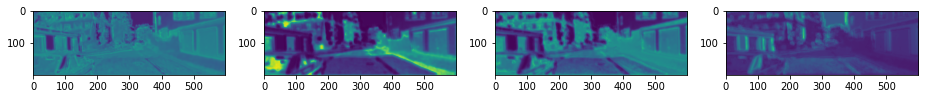

True


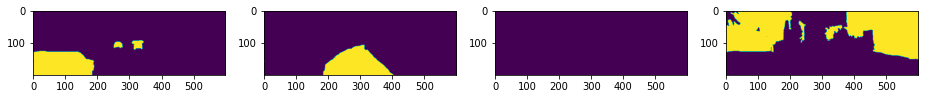


Sample Prediction after epoch 8

Epoch 9/40
5/5 [==============================] - 4s 789ms/step - loss: 1.1771 - dice_coef: 0.4407 - val_loss: 2.0159 - val_dice_coef: 0.1892
Predict


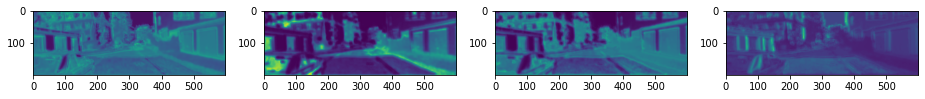

True


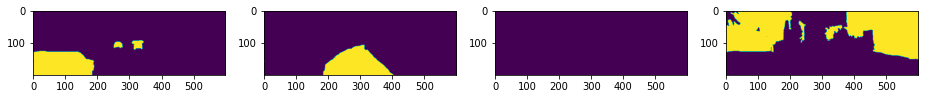


Sample Prediction after epoch 9

Epoch 10/40
5/5 [==============================] - 5s 1s/step - loss: 1.1127 - dice_coef: 0.4719 - val_loss: 1.8931 - val_dice_coef: 0.2032
Predict


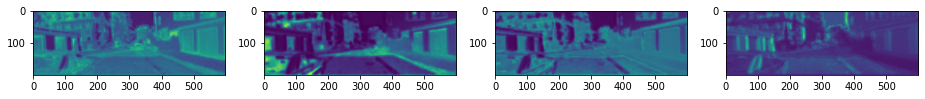

True


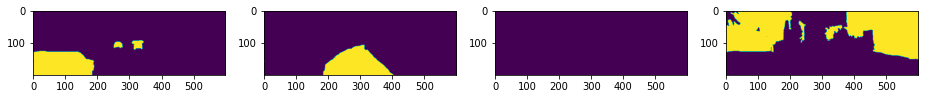


Sample Prediction after epoch 10

Epoch 11/40
5/5 [==============================] - 4s 802ms/step - loss: 1.1492 - dice_coef: 0.4833 - val_loss: 1.8649 - val_dice_coef: 0.2062
Predict


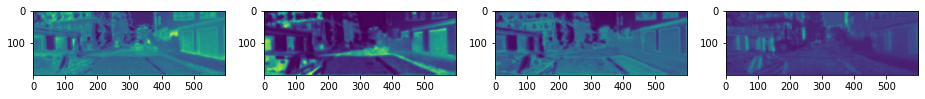

True


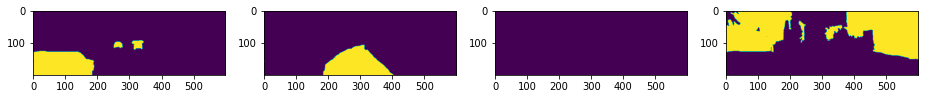


Sample Prediction after epoch 11

Epoch 12/40
5/5 [==============================] - 5s 1s/step - loss: 1.1531 - dice_coef: 0.4725 - val_loss: 1.9200 - val_dice_coef: 0.1899
Predict


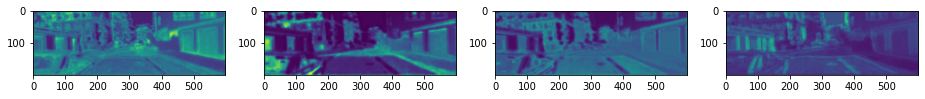

True


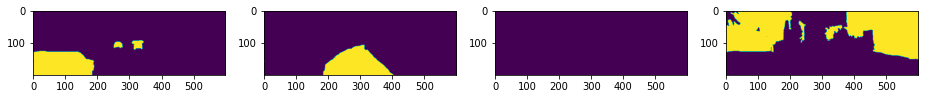


Sample Prediction after epoch 12

Epoch 13/40
5/5 [==============================] - 5s 1s/step - loss: 1.1047 - dice_coef: 0.5004 - val_loss: 1.8677 - val_dice_coef: 0.1996
Predict


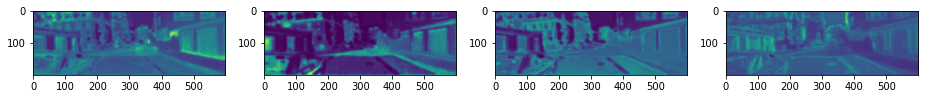

True


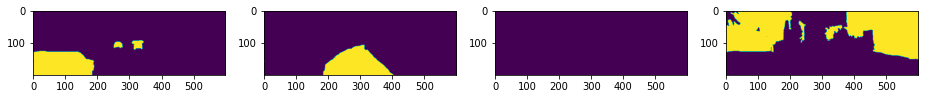


Sample Prediction after epoch 13

Epoch 14/40
5/5 [==============================] - 5s 1s/step - loss: 1.0435 - dice_coef: 0.5104 - val_loss: 1.7751 - val_dice_coef: 0.2194
Predict


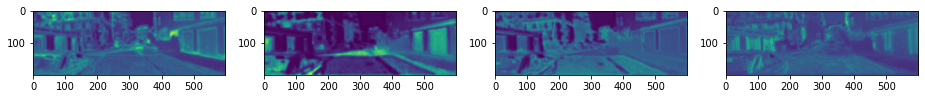

True


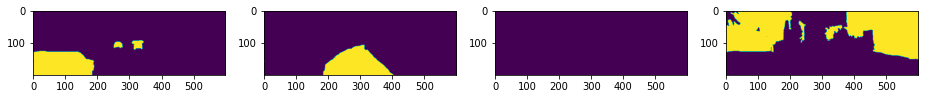


Sample Prediction after epoch 14

Epoch 15/40
5/5 [==============================] - 4s 804ms/step - loss: 0.9817 - dice_coef: 0.5381 - val_loss: 1.7663 - val_dice_coef: 0.2127
Predict


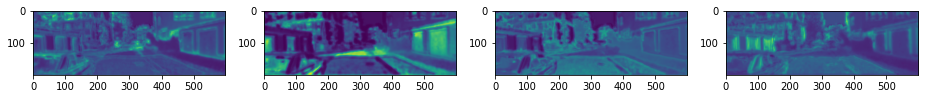

True


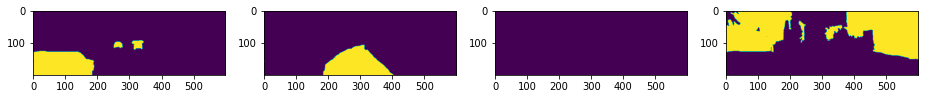


Sample Prediction after epoch 15

Epoch 16/40
5/5 [==============================] - 5s 1s/step - loss: 1.0106 - dice_coef: 0.5345 - val_loss: 1.6072 - val_dice_coef: 0.2509
Predict


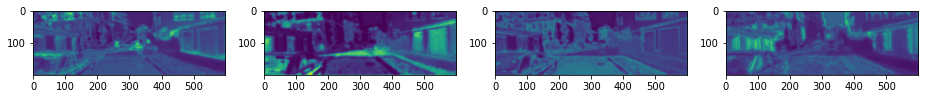

True


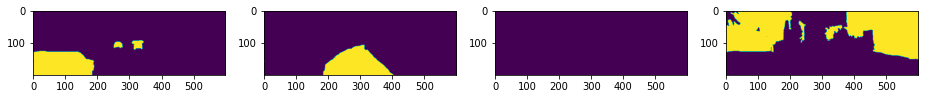


Sample Prediction after epoch 16

Epoch 17/40
5/5 [==============================] - 4s 797ms/step - loss: 0.9510 - dice_coef: 0.5507 - val_loss: 1.5747 - val_dice_coef: 0.2599
Predict


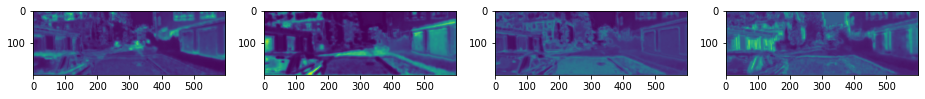

True


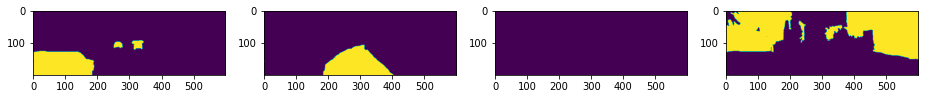


Sample Prediction after epoch 17

Epoch 18/40
5/5 [==============================] - 4s 791ms/step - loss: 0.9359 - dice_coef: 0.5707 - val_loss: 1.4752 - val_dice_coef: 0.2875
Predict


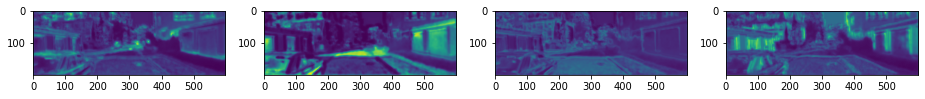

True


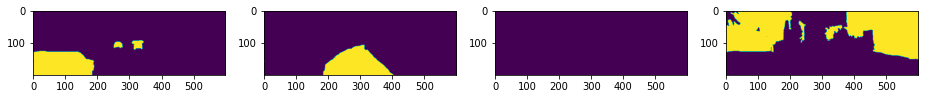


Sample Prediction after epoch 18

Epoch 19/40
5/5 [==============================] - 4s 791ms/step - loss: 0.9420 - dice_coef: 0.5655 - val_loss: 1.4299 - val_dice_coef: 0.3113
Predict


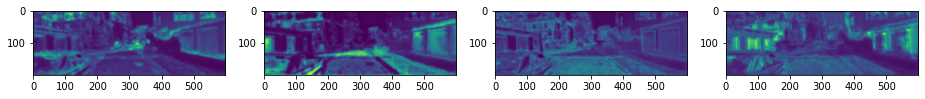

True


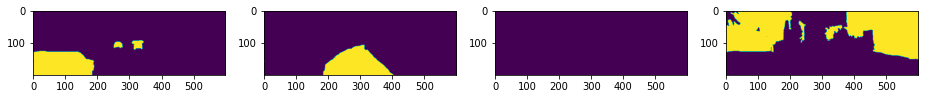


Sample Prediction after epoch 19

Epoch 20/40
5/5 [==============================] - 4s 793ms/step - loss: 0.8873 - dice_coef: 0.5753 - val_loss: 1.4000 - val_dice_coef: 0.3100
Predict


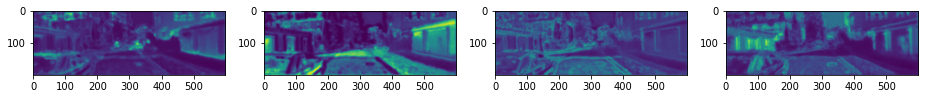

True


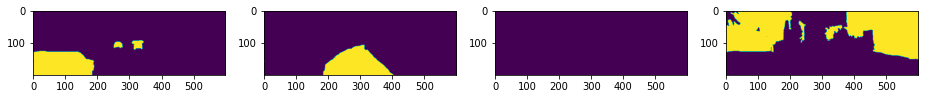


Sample Prediction after epoch 20

Epoch 21/40
5/5 [==============================] - 5s 1s/step - loss: 0.8585 - dice_coef: 0.5802 - val_loss: 1.2669 - val_dice_coef: 0.3618
Predict


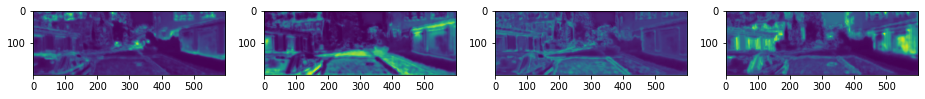

True


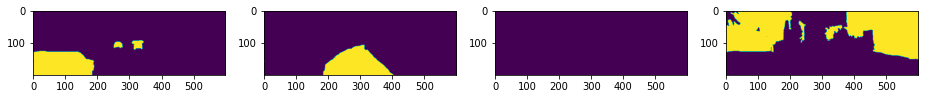


Sample Prediction after epoch 21

Epoch 22/40
5/5 [==============================] - 5s 1s/step - loss: 0.8690 - dice_coef: 0.5938 - val_loss: 1.2363 - val_dice_coef: 0.3894
Predict


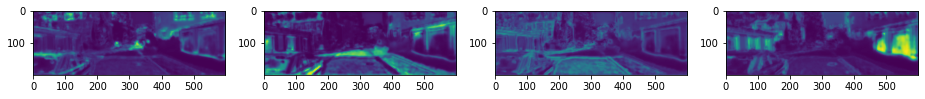

True


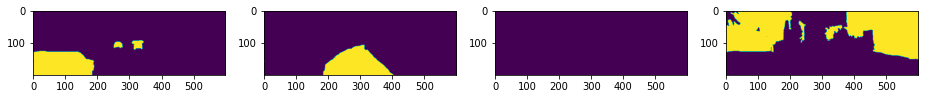


Sample Prediction after epoch 22

Epoch 23/40
5/5 [==============================] - 5s 1s/step - loss: 0.8667 - dice_coef: 0.5935 - val_loss: 1.3046 - val_dice_coef: 0.3682
Predict


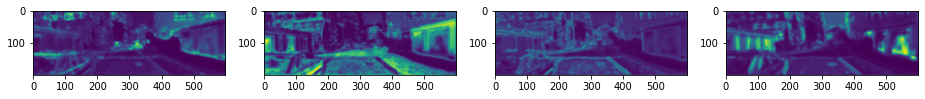

True


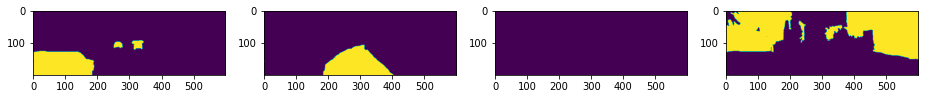


Sample Prediction after epoch 23

Epoch 24/40
5/5 [==============================] - 5s 1s/step - loss: 0.8463 - dice_coef: 0.6098 - val_loss: 1.2911 - val_dice_coef: 0.3947
Predict


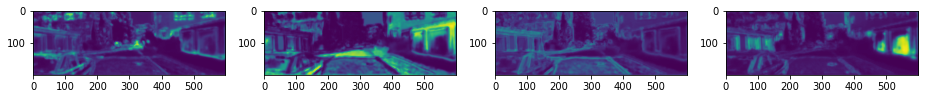

True


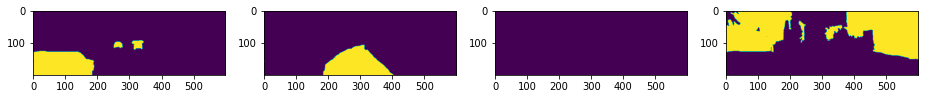


Sample Prediction after epoch 24

Epoch 25/40
5/5 [==============================] - 5s 1s/step - loss: 0.8145 - dice_coef: 0.6040 - val_loss: 1.1137 - val_dice_coef: 0.4554
Predict


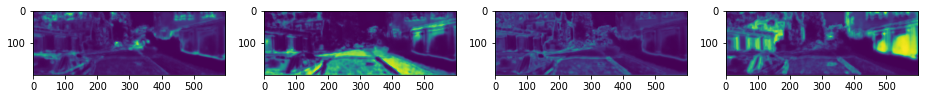

True


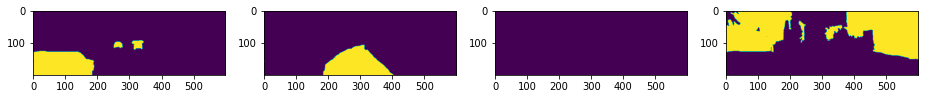


Sample Prediction after epoch 25

Epoch 26/40
5/5 [==============================] - 5s 1s/step - loss: 0.8212 - dice_coef: 0.6114 - val_loss: 0.9762 - val_dice_coef: 0.4990
Predict


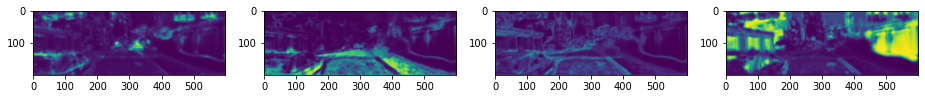

True


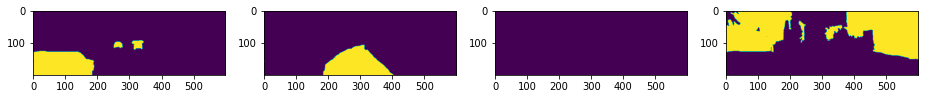


Sample Prediction after epoch 26

Epoch 27/40
5/5 [==============================] - 5s 1s/step - loss: 0.7637 - dice_coef: 0.6328 - val_loss: 1.0817 - val_dice_coef: 0.4731
Predict


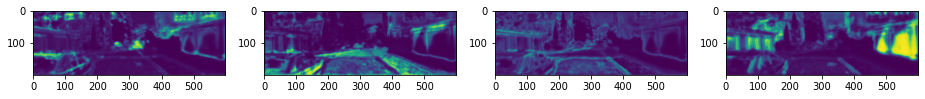

True


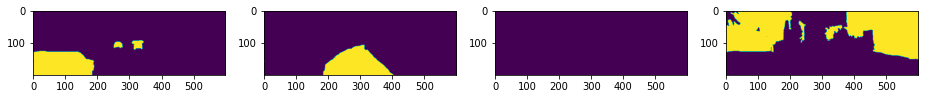


Sample Prediction after epoch 27

Epoch 28/40
5/5 [==============================] - 4s 798ms/step - loss: 0.7783 - dice_coef: 0.6280 - val_loss: 1.1674 - val_dice_coef: 0.4636
Predict


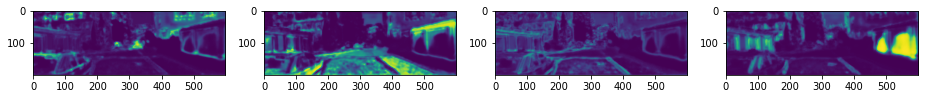

True


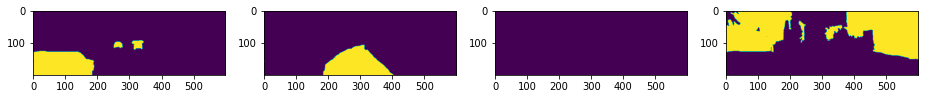


Sample Prediction after epoch 28

Epoch 29/40
5/5 [==============================] - 4s 789ms/step - loss: 0.7374 - dice_coef: 0.6437 - val_loss: 0.9605 - val_dice_coef: 0.5359
Predict


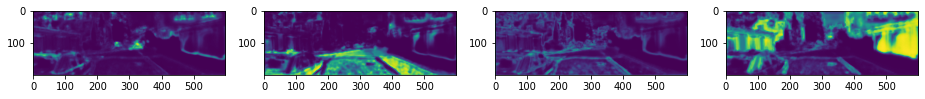

True


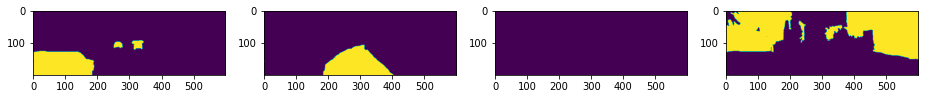


Sample Prediction after epoch 29

Epoch 30/40
5/5 [==============================] - 4s 790ms/step - loss: 0.7830 - dice_coef: 0.6339 - val_loss: 1.2568 - val_dice_coef: 0.4763
Predict


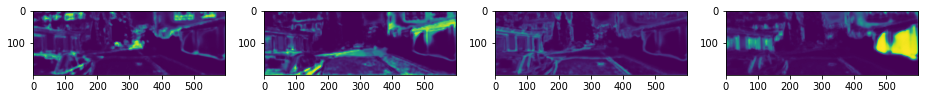

True


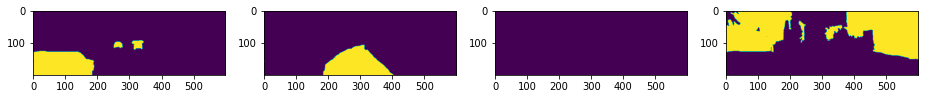


Sample Prediction after epoch 30

Epoch 31/40
5/5 [==============================] - 5s 1s/step - loss: 0.7770 - dice_coef: 0.6370 - val_loss: 0.9322 - val_dice_coef: 0.5477
Predict


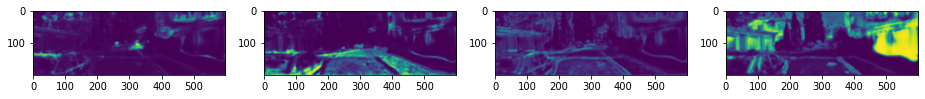

True


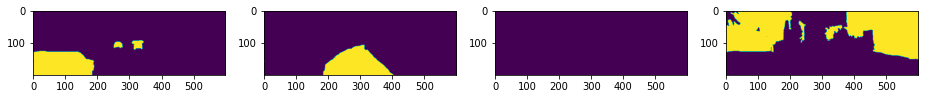


Sample Prediction after epoch 31

Epoch 32/40
5/5 [==============================] - 5s 1s/step - loss: 0.7306 - dice_coef: 0.6445 - val_loss: 0.9286 - val_dice_coef: 0.5494
Predict


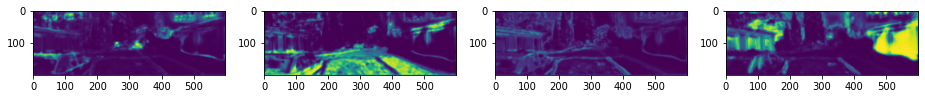

True


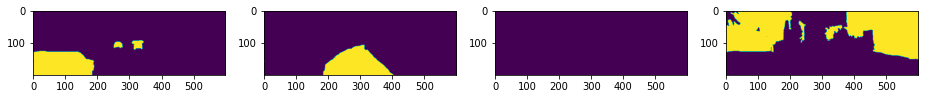


Sample Prediction after epoch 32

Epoch 33/40
5/5 [==============================] - 5s 1s/step - loss: 0.7631 - dice_coef: 0.6399 - val_loss: 0.8891 - val_dice_coef: 0.5888
Predict


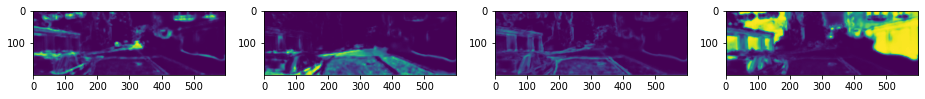

True


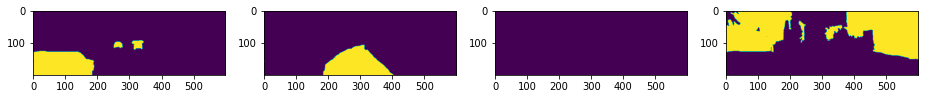


Sample Prediction after epoch 33

Epoch 34/40
5/5 [==============================] - 4s 798ms/step - loss: 0.7199 - dice_coef: 0.6559 - val_loss: 0.8163 - val_dice_coef: 0.6062
Predict


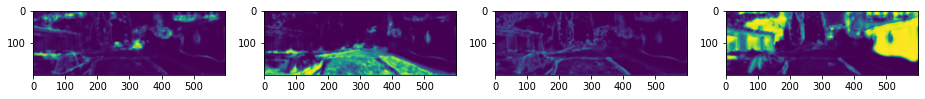

True


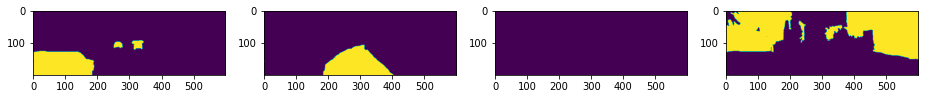


Sample Prediction after epoch 34

Epoch 35/40
5/5 [==============================] - 4s 790ms/step - loss: 0.6820 - dice_coef: 0.6660 - val_loss: 0.8199 - val_dice_coef: 0.6113
Predict


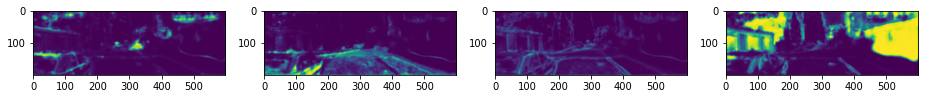

True


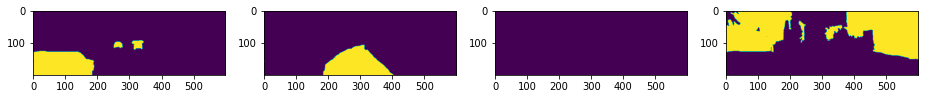


Sample Prediction after epoch 35

Epoch 36/40
5/5 [==============================] - 5s 1s/step - loss: 0.7228 - dice_coef: 0.6523 - val_loss: 0.8224 - val_dice_coef: 0.6063
Predict


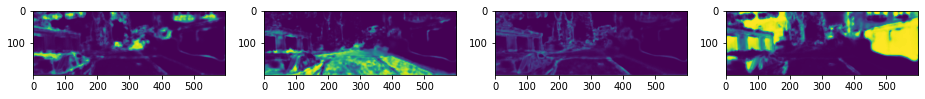

True


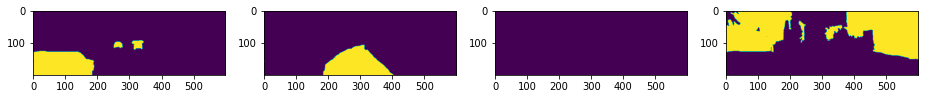


Sample Prediction after epoch 36

Epoch 37/40
5/5 [==============================] - 5s 1s/step - loss: 0.7004 - dice_coef: 0.6669 - val_loss: 0.8076 - val_dice_coef: 0.6004
Predict


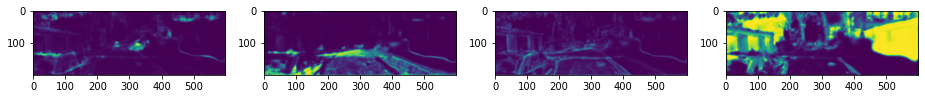

True


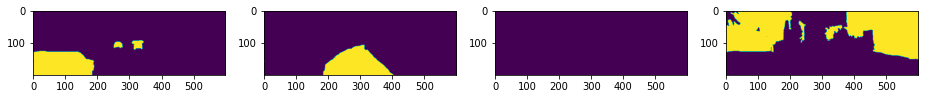


Sample Prediction after epoch 37

Epoch 38/40
5/5 [==============================] - 4s 814ms/step - loss: 0.6932 - dice_coef: 0.6611 - val_loss: 0.8344 - val_dice_coef: 0.5925
Predict


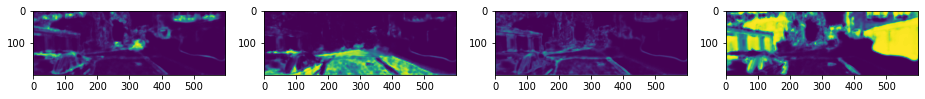

True


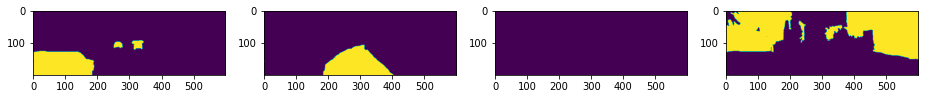


Sample Prediction after epoch 38

Epoch 39/40
5/5 [==============================] - 4s 794ms/step - loss: 0.6943 - dice_coef: 0.6739 - val_loss: 0.7195 - val_dice_coef: 0.6268
Predict


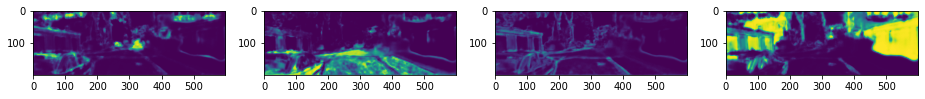

True


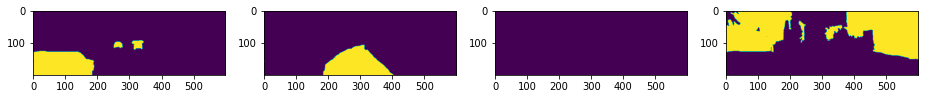


Sample Prediction after epoch 39

Epoch 40/40
5/5 [==============================] - 4s 784ms/step - loss: 0.6550 - dice_coef: 0.6831 - val_loss: 0.7621 - val_dice_coef: 0.6006
Predict


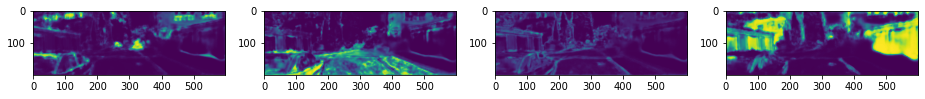

True


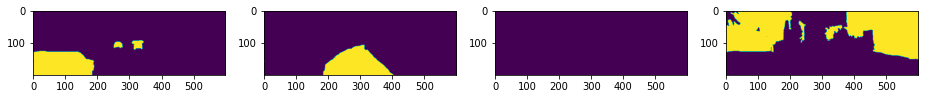


Sample Prediction after epoch 40



In [54]:
history = modelU.fit(xTrain, yTrain, 
                     epochs=40, batch_size=3, 
                     validation_data=(xTrain, yTrain), 
                     callbacks = [tf.keras.callbacks.EarlyStopping( patience=5 ), 
                                  DisplayCallback()])

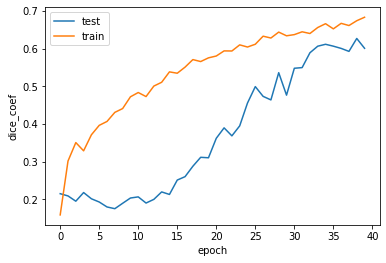

In [55]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

####**Ответ** рез-ты при использовании предобученной  по val_dice_coef несколько выше, но не на много, в предыдущей модели рез-ты быили 0.5 - 0.6.
Т.к тренд на повышение кач-ва, попробую дообучить

Epoch 1/15
5/5 [==============================] - 5s 1s/step - loss: 0.6286 - dice_coef: 0.6970 - val_loss: 0.7423 - val_dice_coef: 0.6233
Predict


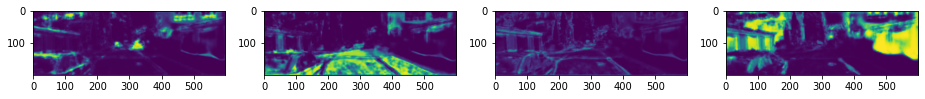

True


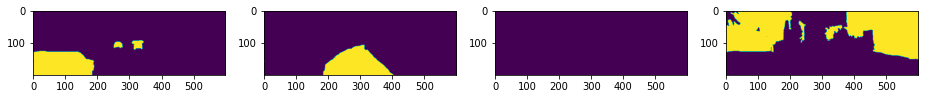


Sample Prediction after epoch 1

Epoch 2/15
5/5 [==============================] - 5s 1s/step - loss: 0.6168 - dice_coef: 0.6979 - val_loss: 0.8384 - val_dice_coef: 0.6185
Predict


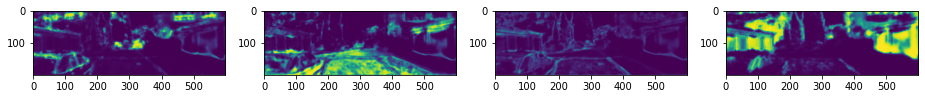

True


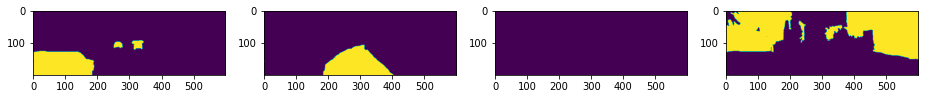


Sample Prediction after epoch 2

Epoch 3/15
5/5 [==============================] - 4s 799ms/step - loss: 0.6210 - dice_coef: 0.7010 - val_loss: 0.8333 - val_dice_coef: 0.6445
Predict


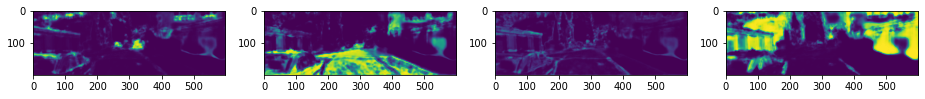

True


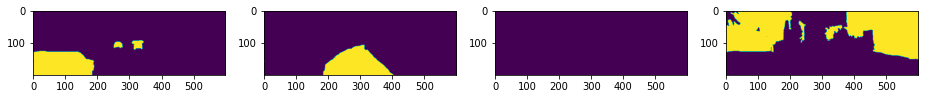


Sample Prediction after epoch 3

Epoch 4/15
5/5 [==============================] - 4s 789ms/step - loss: 0.6041 - dice_coef: 0.7004 - val_loss: 0.8059 - val_dice_coef: 0.6508
Predict


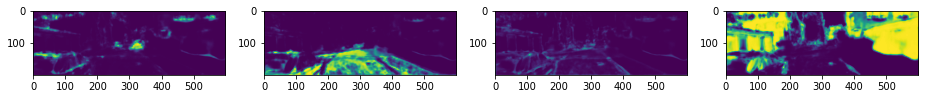

True


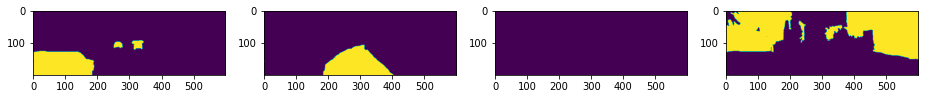


Sample Prediction after epoch 4

Epoch 5/15
5/5 [==============================] - 5s 1s/step - loss: 0.5633 - dice_coef: 0.7176 - val_loss: 0.6998 - val_dice_coef: 0.6794
Predict


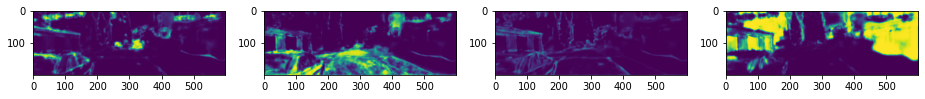

True


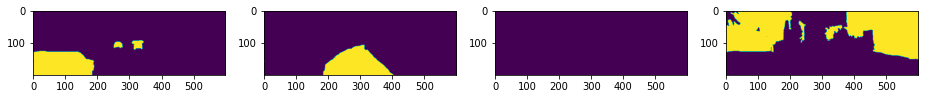


Sample Prediction after epoch 5

Epoch 6/15
5/5 [==============================] - 4s 789ms/step - loss: 0.5660 - dice_coef: 0.7221 - val_loss: 0.7468 - val_dice_coef: 0.6839
Predict


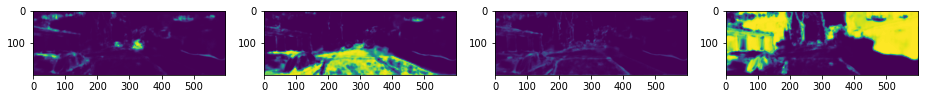

True


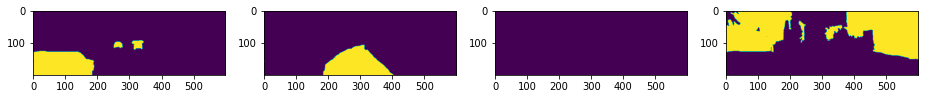


Sample Prediction after epoch 6

Epoch 7/15
5/5 [==============================] - 4s 788ms/step - loss: 0.5238 - dice_coef: 0.7411 - val_loss: 0.6919 - val_dice_coef: 0.6950
Predict


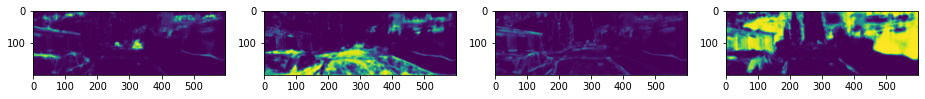

True


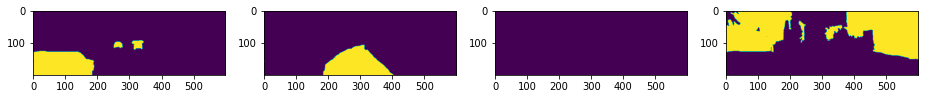


Sample Prediction after epoch 7

Epoch 8/15
5/5 [==============================] - 4s 791ms/step - loss: 0.5294 - dice_coef: 0.7410 - val_loss: 0.6221 - val_dice_coef: 0.7109
Predict


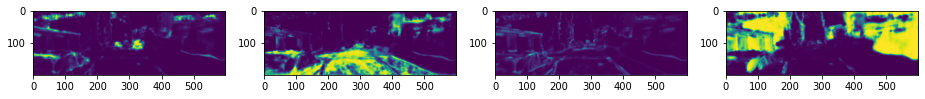

True


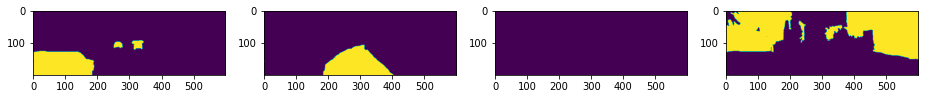


Sample Prediction after epoch 8

Epoch 9/15
5/5 [==============================] - 4s 782ms/step - loss: 0.5565 - dice_coef: 0.7316 - val_loss: 0.6900 - val_dice_coef: 0.6784
Predict


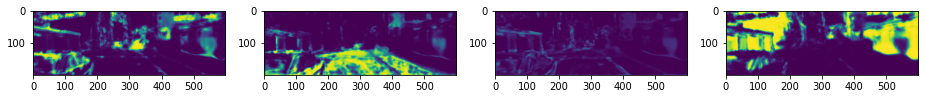

True


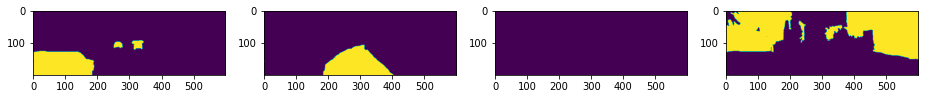


Sample Prediction after epoch 9

Epoch 10/15
5/5 [==============================] - 4s 789ms/step - loss: 0.5908 - dice_coef: 0.7238 - val_loss: 0.7172 - val_dice_coef: 0.6811
Predict


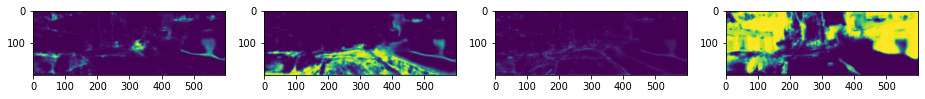

True


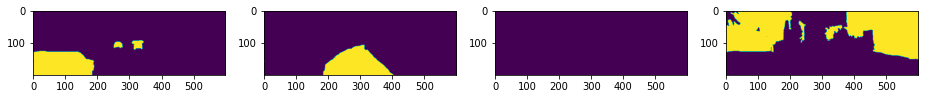


Sample Prediction after epoch 10

Epoch 11/15
5/5 [==============================] - 4s 793ms/step - loss: 0.5718 - dice_coef: 0.7254 - val_loss: 0.9383 - val_dice_coef: 0.5994
Predict


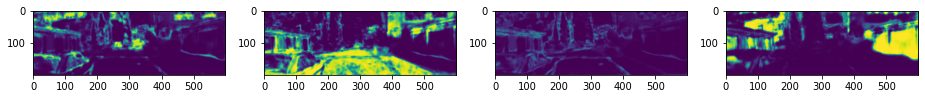

True


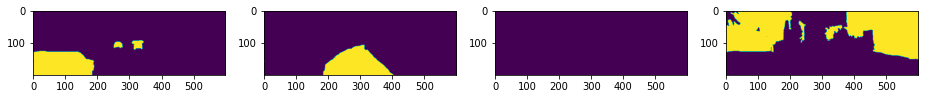


Sample Prediction after epoch 11

Epoch 12/15
5/5 [==============================] - 5s 1s/step - loss: 0.6230 - dice_coef: 0.7075 - val_loss: 0.6690 - val_dice_coef: 0.6783
Predict


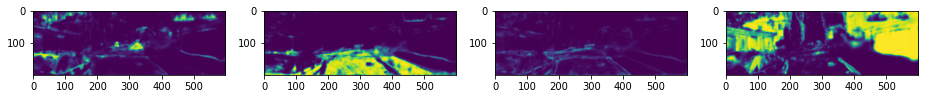

True


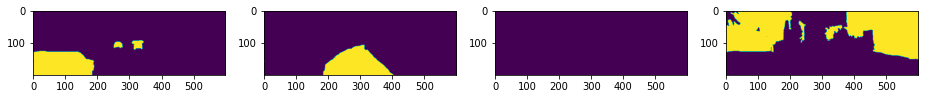


Sample Prediction after epoch 12

Epoch 13/15
5/5 [==============================] - 5s 1s/step - loss: 0.5736 - dice_coef: 0.7260 - val_loss: 0.7715 - val_dice_coef: 0.6310
Predict


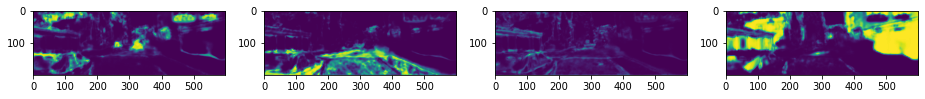

True


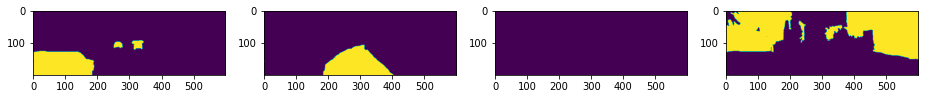


Sample Prediction after epoch 13



In [69]:
history = modelU.fit(xTrain, yTrain, 
                     epochs=15, batch_size=3, 
                     validation_data=(xTrain, yTrain), 
                     callbacks = [tf.keras.callbacks.EarlyStopping( patience=5 ), 
                                  DisplayCallback()])

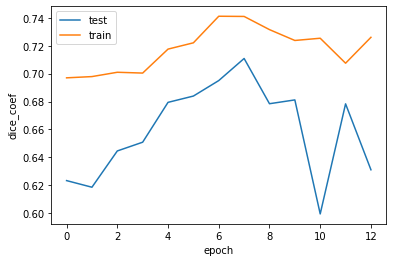

In [70]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

####**Ответ** до 8ой эпохи шел рост потом падение и рез-ты начинают прыгать, возможно пошло переобучение. Дальнейшее обучение показало что модель по рез-там стоит на одном месте.

#Распознаём обучающую выборку

In [71]:
predu = modelU.predict(xTest)
print(predu.shape)

(2, 200, 600, 14)


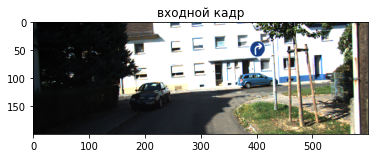

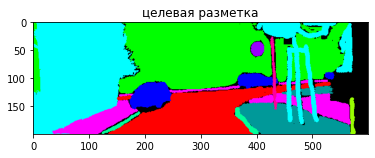

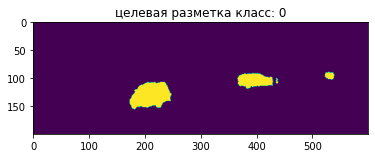

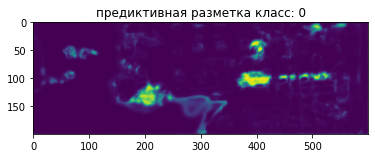

In [72]:
n = 1
class_ = 0
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = predu[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

####**Ответ** на месте машин появились отличимые пятна, но при этом видно что выделяются места отличные от автомобилей.